### IS Proof of concept - DRMABS

In [1]:
import operator
import numpy as np
import seaborn as sns
import pandas as pd
import scipy

In [2]:
import matplotlib.pyplot as plt
import networkx as nx

#pip install pygsp
from pygsp import graphs

In [3]:
import nltk
from nltk import bigrams
import collections

In [4]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

In [5]:
# Files definition
comment_past_nlp_file = 'Datasource\comment_nlp_pasteurized.csv'

In [6]:
def generate_co_occurrence_matrix(corpus):
    vocab = set(corpus)
    vocab = list(vocab)
    vocab_index = {word: i for i, word in enumerate(vocab)}
 
    # Create bigrams from all words in corpus
    bi_grams = list(bigrams(corpus))
 
    # Frequency distribution of bigrams ((word1, word2), num_occurrences)
    bigram_freq = nltk.FreqDist(bi_grams).most_common(len(bi_grams))
 
    # Initialise co-occurrence matrix
    # co_occurrence_matrix[current][previous]
    co_occurrence_matrix = np.zeros((len(vocab), len(vocab)))
 
    # Loop through the bigrams taking the current and previous word,
    # and the number of occurrences of the bigram.
    for bigram in bigram_freq:
        current = bigram[0][1]
        previous = bigram[0][0]
        count = bigram[1]
        pos_current = vocab_index[current]
        pos_previous = vocab_index[previous]
        co_occurrence_matrix[pos_current][pos_previous] = count
    co_occurrence_matrix = np.matrix(co_occurrence_matrix)
 
    # return the matrix and the index
    return co_occurrence_matrix, vocab_index

เปิดไฟล์ที่ได้จากขั้นตอน Data Prep

In [7]:
chk_corpus_list = pd.read_csv(comment_past_nlp_file)

In [8]:
# Make unique
set_unique_list = set(chk_corpus_list['text'])                         
unique_corpus = list(set_unique_list)

สร้าง Co-occurence matrix with biGram

In [9]:
# FOR NETWORKX
bigrm = list(bigrams(chk_corpus_list['text']))
bigrm_cnt = dict(collections.Counter(bigrm))

In [10]:
# FOR PYGSP
matrix, vocab_index = generate_co_occurrence_matrix(set_unique_list)
data_matrix = pd.DataFrame(matrix, index=vocab_index,columns=vocab_index)

In [11]:
data_matrix.head()

,BBQ,นอน,จำนวน,แซ,ลา,แถม,น,บรรยากาศ,แนวทาง,ระบบ,...,posts,ยา,เหรอ,function,ส,แกลลอน,พ,สนทนา,เตา,กก
BBQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
นอน,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
จำนวน,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
แซ,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ลา,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


สร้างกราฟ ซึ่งกราฟนี้จะพบว่าดูยาก ซับซ้อนไปหมด จึงเป็นที่มาทำไมถึงต้องใช้ DRMABS ต่อ

In [12]:
def plot_graph(g):
    fig, ax = plt.subplots(figsize=(15, 8))
    pos = nx.spring_layout(g, k=2)
    nx.draw_networkx(g, pos,
                     font_size=16,
                     width=1,
                     edge_color='grey',
                     node_color='purple',
                     with_labels = False,
                     ax=ax)

    # Create offset labels
    for key, value in pos.items():
        x, y = value[0]+.135, value[1]+.045
        ax.text(x, y,s=key,bbox=dict(facecolor='red', alpha=0.25),
                horizontalalignment='center',fontname='Tahoma', fontsize=9)

    plt.show()

In [13]:
# Create networkx plot 
G = nx.Graph()
# Create connections between nodes
for k, v in bigrm_cnt.items():
    G.add_edge(k[0], k[1], weight=(v * 10))

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 12636 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 12641 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 12636 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 12641 missing from current font.
  font.set_text(s, 0, flags=flags)


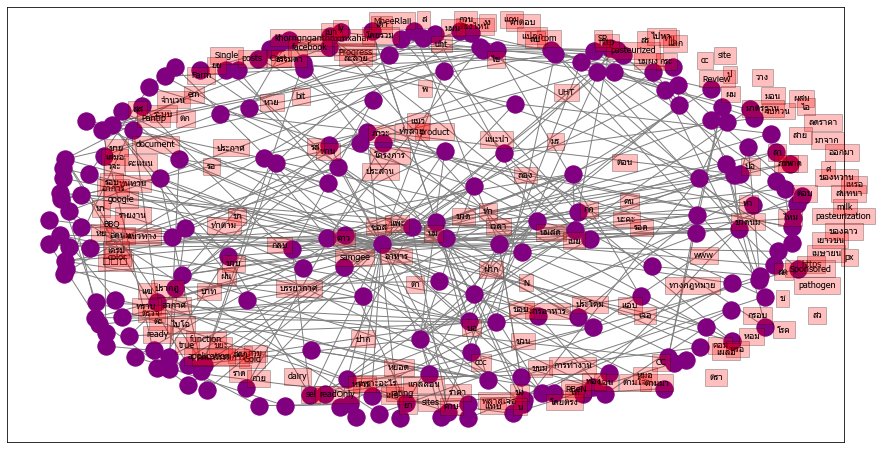

In [14]:
plot_graph(G)

### DRMABS Algorithm

ค้นหา Submarket<br>
1.Community detection for NetworkX : https://python-louvain.readthedocs.io/en/latest/<br>
2.Multilevel graph coarsening algorithm : https://github.com/loukasa/graph-coarsening<br>
<br>
(i) identify the number of existing submarkets (if any)<br>
(ii) identify the products belonging to each submarket<br>
(iii) obtain an indication of the quality of our segmentation.
<br>Liu et al. <i>Overlapping Community Detection Algorithm Based on Coarsening and Local Overlapping Modularity</i>

In [24]:
# pip install community
# pip install python-louvain
from community import community_louvain
import matplotlib.cm as cm

In [16]:
# pip install . (ต้องโคลนจาก Git)
from graph_coarsening.coarsening_utils import *
import graph_coarsening.graph_utils

In [17]:
def get_highest_centrality(g,k):
    cen_df = pd.DataFrame()
    cen_df = cen_df.append(nx.edge_betweenness_centrality(g), ignore_index=True).fillna(0)
    cen_T_df = cen_df.T
    cen_T_df = cen_T_df.reset_index()
    cen_T_df.columns = ['bigram','central']
    hl_df = pd.DataFrame(cen_T_df['bigram'].tolist()) 
    cc_df = pd.concat([cen_T_df, hl_df], axis=1, sort=False)
    cc_df.columns = ['bigram','central','nodeX','nodeY']
    cc_df['nodeX'] = cc_df['nodeX'].str.strip()
    grouped_cc_df = cc_df.groupby("nodeX").max()
    #grouped_cc_df = cc_df.max()
    grouped_cc_df = grouped_cc_df.reset_index()
    grouped_cc_df = grouped_cc_df.sort_values(by=['central'],ascending=False)
    return grouped_cc_df[0:k]

In [18]:
def get_neigbor(g,hub):
    nb = []
    if g.has_node(hub):
        nb = [x for x in g.neighbors(hub)]
    return nb

In [19]:
# Create networkx plot 
G = nx.Graph()
# Create connections between nodes
for k, v in bigrm_cnt.items():
    G.add_edge(k[0], k[1], weight=(v * 10))

In [20]:
# Coarsening, Mikhail et al. 
# Heuristic Algorithm for Approximation Betweenness Centrality Using Graph Coarsening (2015)

num_hubs = G.number_of_nodes()
G2 = nx.Graph()
G2 = G

hubs_list = get_highest_centrality(G,60) # หาตัวใหญ่ max k=60
for cnt,hub in enumerate(hubs_list['nodeX'],0):
    vertex_conn = set()
    vertice_del = get_neigbor(G, hub) # หาเพื่อนโดยตรง
    for vertex in vertice_del:        # หาเพื่อนของเพื่อน
        vertex_conn = vertex_conn.union(set(get_neigbor(G, vertex)))
    for vertex in vertice_del:        # ลบเพื่อนโดยตรงของตัวใหญ่
        G2.remove_node(vertex)
    for vertex in vertex_conn:        # เชื่อมตัวใหญ่กับเพื่อนของเพื่อน
        if vertex not in vertice_del: # Avoid recursive กลับไปเชื่อมกับตัวเก่า
            G2.add_edge(hub, vertex)

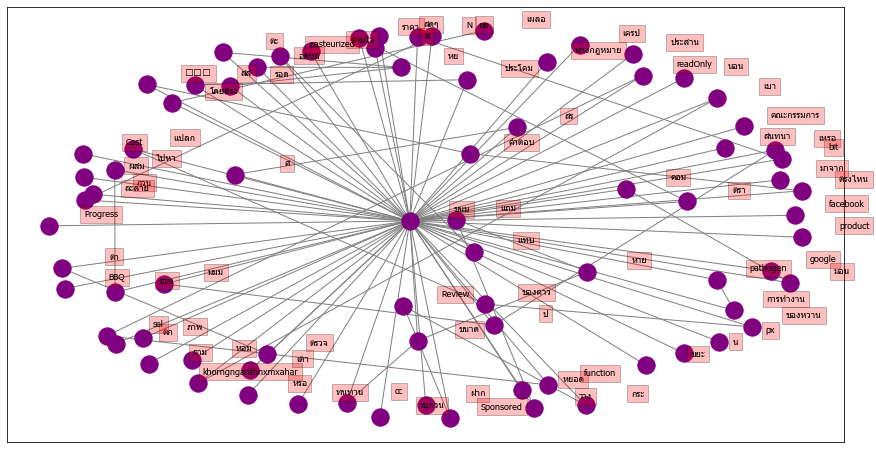

In [21]:
plot_graph(G2)

In [25]:
# Com-detection louvain
partition = community_louvain.best_partition(G2)

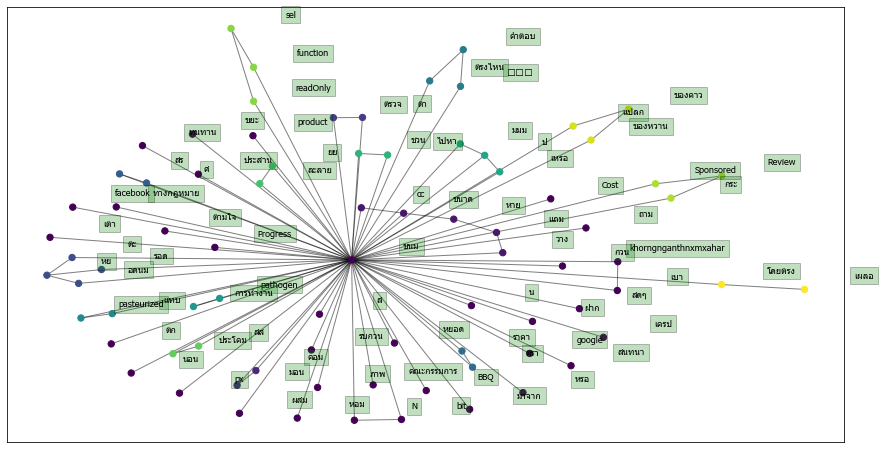

In [26]:
fig = plt.figure(figsize=(15, 8))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = plt.subplot()

pos = nx.spring_layout(G2)
#color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G2, pos, partition.keys(), node_size=40, cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G2, pos, alpha=0.5)

for key, value in pos.items():
    x, y = value[0]+.135, value[1]+.045
    ax.text(x, y,s=key,bbox=dict(facecolor='green', alpha=0.25),
            horizontalalignment='center',fontname='Tahoma', fontsize=9)
plt.show()

Map submarket globally

Map product locally, optimized globally

Add asymmetry